# 0. ETF Selection

We select the SPDR Gold Shares (GLD) ETF as the gold ETF. It is traded on Nasdaq, the currency is USD.

Similarly, we choose the Amundi CAC 40 UCITS ETF-C (C40.PA) as the equity ETF. It will track the CAC 40 index of France. It is traded on Paris Euronext, the currency is EUR.

The currency for Bitcoin is USD.

Data source: https://finance.yahoo.com/

# 1. Data Importing

In [1]:
import arch
import holidays
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, coint
%matplotlib inline

In [2]:
gold_df = pd.read_csv("data/SPDR Gold Shares (GLD) Jan - Dec 2020.csv")
equity_df = pd.read_csv("data/Amundi CAC 40 UCITS ETF-C (C40.PA) Jan 2020 - Dec 2020.csv")
bitcoin_df = pd.read_csv('data/Bitcoin USD (BTC-USD) Jan 2020 - Dec 2020.csv')

Convert the data into the datetime format and make it the index to query the dataframe easier.

In [3]:
def convert_df(df):
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)   
    return df

gold_df = convert_df(gold_df)
equity_df = convert_df(equity_df)
bitcoin_df = convert_df(bitcoin_df)


Verify that the time range is correct.

In [4]:
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500
2020-01-08,148.490005,148.610001,146.139999,146.860001,146.860001,22248500


In [5]:
gold_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,175.100006,176.210007,175.059998,175.649994,175.649994,6542800
2020-12-24,175.550003,176.369995,175.509995,176.350006,176.350006,3695400
2020-12-28,177.259995,177.910004,175.630005,175.710007,175.710007,7778700
2020-12-29,176.250000,176.970001,175.570007,176.350006,176.350006,5983700
2020-12-30,176.440002,177.720001,176.440002,177.699997,177.699997,5914000


In [6]:
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,88.589996,89.239998,88.589996,89.239998,89.239998,124.0
2020-01-03,88.489998,88.889999,88.309998,88.769997,88.769997,0.0
2020-01-06,88.529999,88.599998,87.750000,88.559998,88.559998,563.0
2020-01-07,88.839996,89.260002,88.500000,88.500000,88.500000,0.0
2020-01-08,88.120003,89.300003,88.120003,89.139999,89.139999,212.0


In [7]:
equity_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,82.480003,83.330002,82.000000,83.250000,83.250000,68117.0
2020-12-24,83.419998,83.550003,82.930000,83.139999,83.139999,32892.0
2020-12-28,83.849998,84.290001,83.410004,84.160004,84.160004,20640.0
2020-12-29,84.440002,84.680000,84.320000,84.449997,84.449997,20668.0
2020-12-30,84.489998,84.699997,84.300003,84.339996,84.339996,3829.0


In [8]:
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664996
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481031
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271274
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074094


In [9]:
bitcoin_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,26272.294922,66479895605
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,27084.808594,49056742892
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,27362.437500,45265946774
2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,28840.953125,51287442703
2020-12-31,28841.574219,29244.876953,28201.992188,29001.720703,29001.720703,46754964848


# 2. Data Processing

We use adjusted close prices to calculate the daily returns. Adjusted close prices are the prices that already take into account stock split and dividends, which reflex more accurate the change of the prices.

In [10]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800,NaN
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800,0.013269
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300,0.010489
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500,0.003935
2020-01-08,148.490005,148.610001,146.139999,146.860001,146.860001,22248500,-0.007502


In [11]:
equity_df["Daily Return"] = equity_df["Adj Close"].pct_change(1)
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-01-02,88.589996,89.239998,88.589996,89.239998,89.239998,124.0,NaN
2020-01-03,88.489998,88.889999,88.309998,88.769997,88.769997,0.0,-0.005267
2020-01-06,88.529999,88.599998,87.750000,88.559998,88.559998,563.0,-0.002366
2020-01-07,88.839996,89.260002,88.500000,88.500000,88.500000,0.0,-0.000677
2020-01-08,88.120003,89.300003,88.120003,89.139999,89.139999,212.0,0.007232


In [12]:
bitcoin_df["Daily Return"] = bitcoin_df["Adj Close"].pct_change(1)
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664996,NaN
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,-0.029819
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481031,0.051452
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271274,0.008955
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074094,0.000089


# 3. Data Summaries

In [13]:
# Helper
df_names = {0: "gold ETF", 1: "equity ETF", 2: "Bitcoin"}
dfs = [gold_df, equity_df, bitcoin_df]
def get_data(df, month_start, month_end, column=None):
    data = df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")]
    if column: 
        data = data[column]
    return data

In [14]:
def summarize_data(df):
    data = get_data(df, 3, 12, "Adj Close")
    moving_avg = data.rolling(20, min_periods=1).mean()
    return get_data(moving_avg, 4, 12)


We can check that the data is null for several days of the equity time series. For that reason, for the windows that have a null value, we'll take the average of the rest as an approximate.

In [15]:
equity_df.isna().sum()

Open            5
High            5
Low             5
Close           5
Adj Close       5
Volume          5
Daily Return    1
dtype: int64

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for gold ETF from April to December


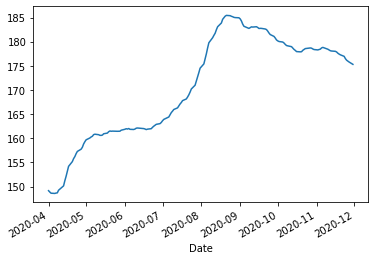

Date
2020-04-01    149.164499
2020-04-02    148.884998
2020-04-03    148.639998
2020-04-06    148.593498
2020-04-07    148.671498
Name: Adj Close, dtype: float64
Date
2020-11-23    176.975001
2020-11-24    176.503500
2020-11-25    176.172500
2020-11-27    175.792000
2020-11-30    175.315500
Name: Adj Close, dtype: float64
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for equity ETF from April to December


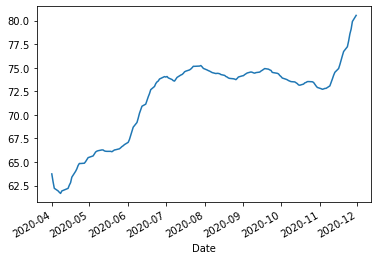

Date
2020-04-01    63.739499
2020-04-02    62.921499
2020-04-03    62.211000
2020-04-06    61.938000
2020-04-07    61.789000
Name: Adj Close, dtype: float64
Date
2020-11-24    77.861000
2020-11-25    78.606500
2020-11-26    79.120526
2020-11-27    79.925263
2020-11-30    80.572105
Name: Adj Close, dtype: float64
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for Bitcoin from April to December


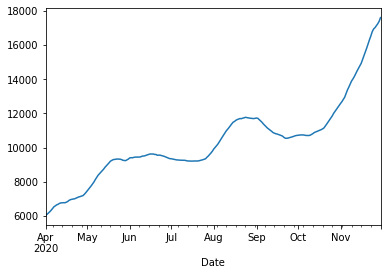

Date
2020-04-01    6034.907422
2020-04-02    6096.403296
2020-04-03    6173.054346
2020-04-04    6246.814966
2020-04-05    6335.647437
Name: Adj Close, dtype: float64
Date
2020-11-26    17011.312500
2020-11-27    17125.044922
2020-11-28    17236.937256
2020-11-29    17379.195703
2020-11-30    17595.942383
Name: Adj Close, dtype: float64


In [16]:
moving_avgs = []
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"Moving average for {df_names[index]} from April to December")
    data = summarize_data(df)
    data.plot()
    plt.show()
    print(data.head())
    print(data.tail())
    moving_avgs.append(data)

# 4. Graphing

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for gold ETF from April to December


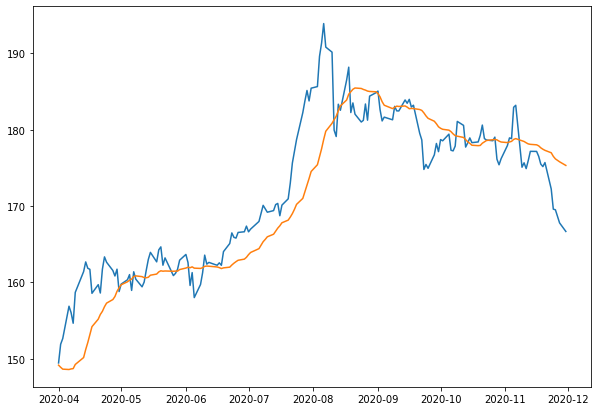

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for equity ETF from April to December


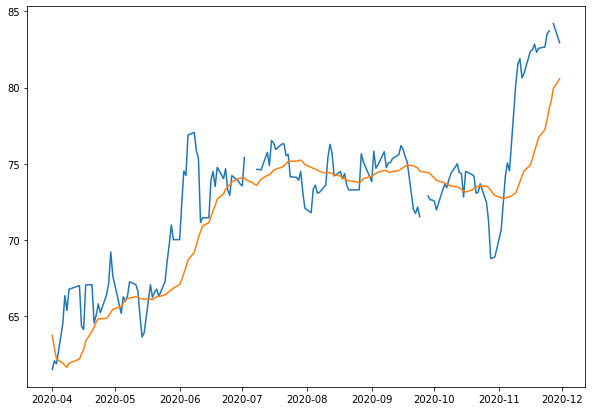

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for Bitcoin from April to December


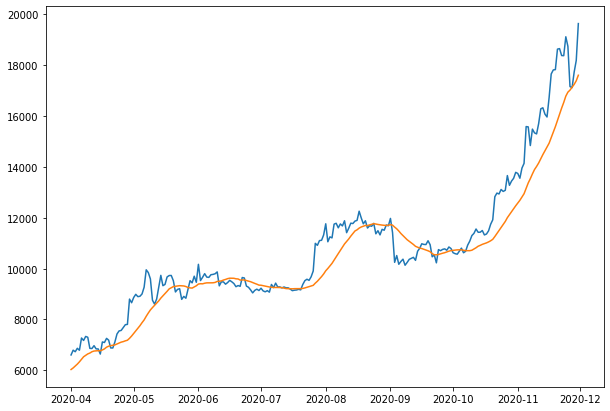

In [17]:
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"The prices and its moving averages for {df_names[index]} from April to December")
    data = get_data(df, 4, 12, "Adj Close")
    moving_avg = moving_avgs[index]
    plt.figure(figsize=(10,7))
    plt.plot(data)
    plt.plot(moving_avg)
    plt.show()

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of gold ETF and equity ETF from April to December


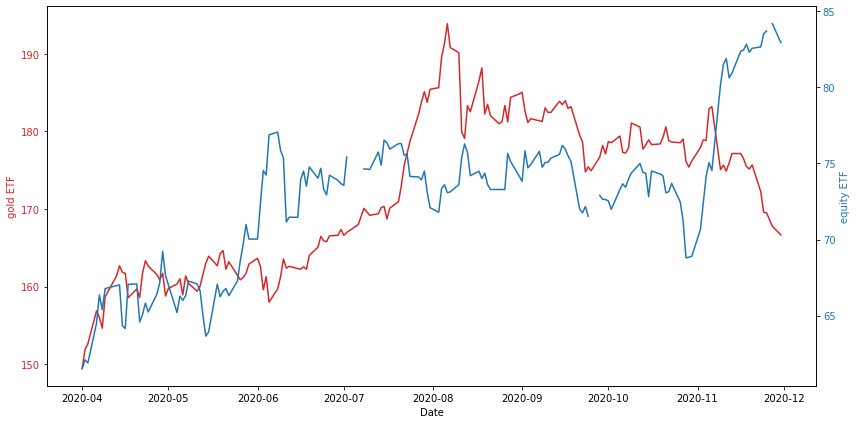

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of gold ETF and Bitcoin from April to December


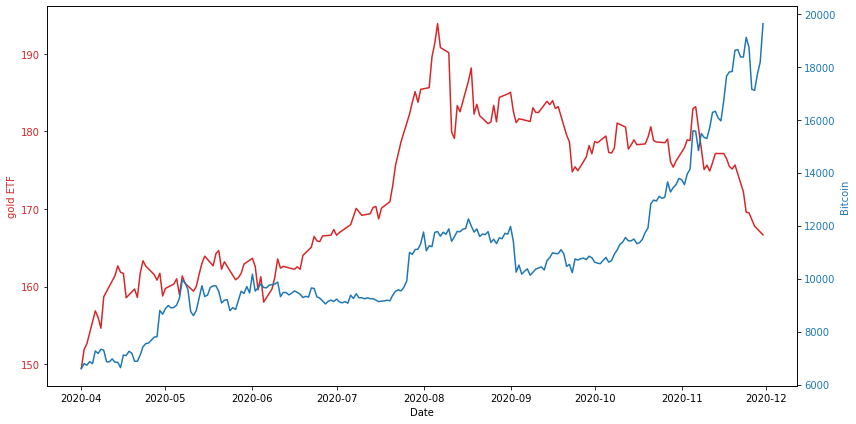

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of equity ETF and Bitcoin from April to December


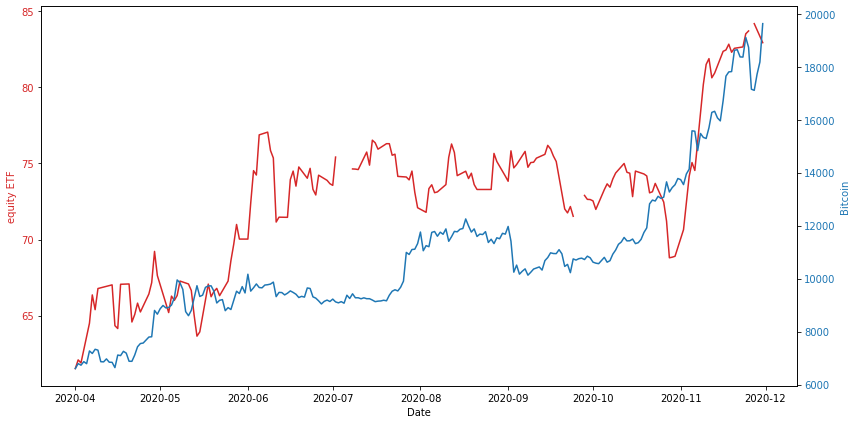

In [18]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"The prices of {df_names[i]} and {df_names[j]} from April to December")
    y1_data = get_data(dfs[i], 4, 12, "Adj Close")
    y2_data = get_data(dfs[j], 4, 12, "Adj Close")
    fig, y1_axis = plt.subplots(figsize=(12,6))

    y1_color = 'tab:red'
    y2_color = 'tab:blue'

    y1_axis.set_xlabel('Date')
    y1_axis.set_ylabel(df_names[i], color=y1_color)
    y1_axis.plot( y1_data, color=y1_color)
    y1_axis.tick_params(axis='y', labelcolor=y1_color)
    y2_axis = y1_axis.twinx() 


    y2_axis.set_ylabel(df_names[j], color=y2_color)  
    y2_axis.plot( y2_data, color=y2_color)
    y2_axis.tick_params(axis='y', labelcolor=y2_color)

    fig.tight_layout()  
    plt.show()

# 5. Fitting a GARCH model

In [19]:
def get_data(df, month_start, month_end, column):
    return df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")][column]

In [20]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='GARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())

In [21]:
for model in ["GARCH", "EGARCH", "FIGARCH", "TARCH"]:
    for index, df in enumerate(dfs):
        print("-" * 78)
        print("-" * 78)
        print("-" * 78)
        print(f"{model} model for {df_names[index]} from April to December")
        data = get_data(df, 4, 12, "Daily Return")
        data = data.dropna()
        fit_garch(data, model)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
GARCH model for gold ETF from April to December
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1673877460.7820969
Iteration:      2,   Func. Count:     17,   Neg. LLF: 435215224.2839473
Iteration:      3,   Func. Count:     28,   Neg. LLF: 143105.50993086948
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1386.9894599170627
Iteration:      5,   Func. Count:     49,   Neg. LLF: 6458.009028479763
Iteration:      6,   Func. Count:     60,   Neg. LLF: 2036350.0669641267
Iteration:      7,   Func. Count:     71,   Neg. LLF: 530107.6412494654
Iteration:      8,   Func. Count:     82,   Neg. LLF: 3889.890662983201
Iteration:      9,   Func. Count:     92,   Neg. LLF: 9165577.087753514
Iteration:     10,   Func. Count:    102,   Neg. LLF: -520.3856

C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Py


Iteration:     22,   Func. Count:    152,   Neg. LLF: -528.0220933823332
Iteration:     23,   Func. Count:    158,   Neg. LLF: 201.13195377988998
Iteration:     24,   Func. Count:    173,   Neg. LLF: 442.0724567331608
Iteration:     25,   Func. Count:    188,   Neg. LLF: 454.1457239684926
Iteration:     26,   Func. Count:    197,   Neg. LLF: 459.4403120865055
Iteration:     27,   Func. Count:    210,   Neg. LLF: 74943590.29556805
Iteration:     28,   Func. Count:    217,   Neg. LLF: -299.62341096303146
Iteration:     29,   Func. Count:    232,   Neg. LLF: 141253854.47446996
Iteration:     30,   Func. Count:    247,   Neg. LLF: 214123641.19401747
Iteration:     31,   Func. Count:    262,   Neg. LLF: 213869099.33214104
Iteration:     32,   Func. Count:    277,   Neg. LLF: 213864249.3891438
Iteration:     33,   Func. Count:    292,   Neg. LLF: 213862994.01357386
Iteration:     34,   Func. Count:    307,   Neg. LLF: 213862629.33215892
Iteration:     35,   Func. Count:    322,   Neg. LLF: 

C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Py

                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:           Daily Return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                    FIGARCH   Log-Likelihood:                455.584
Distribution:                  Normal   AIC:                          -901.167
Method:            Maximum Likelihood   BIC:                          -885.459
                                        No. Observations:                  171
Date:                Tue, Jan 26 2021   Df Residuals:                      166
Time:                        20:44:09   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.2236e-03  1.126e-03      1.086      0.277 

Iteration:     10,   Func. Count:     77,   Neg. LLF: -458.1778753572639
Iteration:     11,   Func. Count:     83,   Neg. LLF: -458.1786064116576
Iteration:     12,   Func. Count:     89,   Neg. LLF: -458.1787575017956
Iteration:     13,   Func. Count:     95,   Neg. LLF: -458.1787635968352
Iteration:     14,   Func. Count:    100,   Neg. LLF: -458.17876359582436
Optimization terminated successfully    (Exit mode 0)
            Current function value: -458.1787635968352
            Iterations: 14
            Function evaluations: 100
            Gradient evaluations: 14
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:           Daily Return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                TARCH/ZARCH   Log-Likelihood:                458.179
Distribution:                  Normal   AIC:                          -906.358
Method:            Maximum L

C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Py

# 6. Assessing stationarity

Use Augmented Dickey-Fuller test with regression = "c" to test for stationary

In [22]:
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"Test stationary for {df_names[index]} from April to December")
    X = get_data(df, 4, 12, "Daily Return").values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Test stationary for gold ETF from April to December
ADF Statistic: -12.841103
p-value: 0.000000
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Test stationary for equity ETF from April to December
ADF Statistic: -12.611649
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------

For all there time series, we can reject the null hypothesis that there is a unit root in the time series and the time series are stationary.

In [23]:
data = get_data(gold_df, 4, 12, "Daily Return")
X = data.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.841103
p-value: 0.000000
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [24]:
data = get_data(equity_df, 4, 12, "Daily Return")
X = data.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.611649
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [25]:
data = get_data(bitcoin_df, 4, 12, "Daily Return")
X = data.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.826285
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


# 7. Modelling Cointegration

In [26]:
data1 = get_data(gold_df, 4, 6, "Daily Return").values[:40]
data2 = get_data(equity_df, 4, 6, "Daily Return").values[:40]
data3 = get_data(bitcoin_df, 4, 6, "Daily Return").values[:40]

In [27]:
data1.shape

(40,)

In [28]:
data2.shape

(40,)

In [29]:
np.array([data2, data3]).T.shape

(40, 2)

In [30]:
coint(data1, np.array([data2, data3]).T)

(-6.648151460210049,
 2.7474754243662576e-07,
 array([-4.68490329, -3.96689229, -3.61396547]))

In [31]:
coint(data2, np.array([data1, data3]).T)

(-2.805957223005444,
 0.32710831341121016,
 array([-4.68490329, -3.96689229, -3.61396547]))

In [32]:
coint(data3, np.array([data1, data2]).T)

(-6.0138232700591665,
 7.803532494570396e-06,
 array([-4.68490329, -3.96689229, -3.61396547]))